In [1]:
from collections import defaultdict
import pickle
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union
from StocksPool import *
from PerfCalc import *

# Backtest Configuration

In [2]:
####################################################
#                      Change                      #
####################################################
config_dict = {
    ###############   回测参数设定   ################
    'date_start': '20170101',       # 回测起始时间
    'date_end': '20221231',     # 回测结束时间
    "freq": 1,         # 调仓频率(几个交易日调仓一次)
    "TxFee": 0.0015,        # 双边交易成本(一般为买+卖0.0006 & 印花税0.0010, 因此通常粗略设为0.0015)
    "group_num": 10,        # 回测分组组数
    "index_code": '000985',     # 基准指数
    "cumMethod": 'cumprod',     # 累积收益率计算方式：cumsum累加/cumprod累乘
    "weight_method": 'ew',      # 组内加权方式：ew等权，vw市值加权，fw因子值加权
    "stock_group_name": ['All_A'],      # 股池：'All_A':全A选股, 'hs300':沪深300, 'zz500':中证 500, 'zz1000':中证1000, 'zz1800':沪深300+中证500+中证 1000
    "bottom_num": [400,200],       # Bottom(多头)组股票数量
    "del_stop":True,        # 是否剔除停牌股
    "del_st": True,     # 是否剔除st股票
    "del_new": True,        # 是否剔除上市250个交易日内的(次)新股
    "strategy_type": "close2close",     # 股票收益率计算方式
    "factor_path":"./DailyFactors/factor_score_re.pq",      # your factor path

    ###############   backtest dataset paths (DO NOT change)  ################
    "PATH":{
        'daily_index_path': 'backtest_data/index_quote.pkl',
        'daily_rehabpackage_path': 'backtest_data/daily_rehabPackage_path.pkl',
        'index_component_path': 'backtest_data/index_component.pkl',
        'st_stocks_path': 'backtest_data/st_stocks.pkl',
        'de_stocks_path': 'backtest_data/de_stock.pkl',
        'subnew_stocks_path': 'backtest_data/no_one_year_stock.pkl',
    },
}

In [3]:
####################################################
#                   DO NOT change                  #
####################################################
config_dict["num_tuple"] = (
    tuple(zip(range(0, 100, 100 // config_dict['group_num']),range(100 // config_dict['group_num'], 101, 100 // config_dict['group_num'])))
                            )
config_dict["TIME"] = {
    'date_start': config_dict['date_start'],
    'date_end': config_dict['date_end'],
    'datetime_start': pd.to_datetime(config_dict['date_start']),
    'datetime_end': pd.to_datetime(config_dict['date_end'])
}


factor_df = pd.read_parquet(config_dict['factor_path'])
factor_df.index = pd.to_datetime(factor_df.index)
config_dict['factor_df'] = factor_df

# Preprocessing

In [4]:
####################################################
#                   DO NOT change                  #
####################################################
# What this cell is doing
# 1. Calculate daily return
# 2. Set date-range & exclude ST/UpAndDownLimit/Non-Tradeable stocks

def DataLoading(data_pack, _config_dict):
    f1 = open(config_dict['PATH']['daily_index_path'], 'rb')
    IndexPri = pickle.load(f1)
    IndexPri['TradingDay'] = pd.to_datetime(IndexPri['TradingDay'])
    f1.close()
    index_closePri = IndexPri.pivot(index='TradingDay', columns='Index_code', values='ClosePrice')

    strategy_type = _config_dict['strategy_type']
    if strategy_type == 'close2close':
        ret = data_pack_all['close'].pct_change()
        ret = ret.replace({np.inf: np.nan, -np.inf: np.nan})
        data_pack['return'] = ret

    elif strategy_type == 'open2open':
        ret = data_pack_all['open'].pct_change()
        ret = ret.replace({np.inf: np.nan, -np.inf: np.nan})
        data_pack['return'] = ret
        data_pack['return'] = ret.shift(-1)
    else:
        return ValueError("strategy_type only support open2open or close2close in config_dict")
    return data_pack,index_closePri

def datetime_filter(data_pack, _IndexPri, _config_dict):
    time_cfg = _config_dict["TIME"]
    _factor_df = _config_dict["factor_df"]
    for key in data_pack.keys():
        temp = data_pack[key]
        data_pack[key] = temp[
            (temp.index >= time_cfg['date_start']) & (temp.index <= time_cfg['date_end'])]

    _IndexPri = _IndexPri[
        (_IndexPri.index >= time_cfg['date_start']) & (_IndexPri.index <= time_cfg['date_end'])]
    _factor_final = data_pack['return'] * np.nan
    _factor_final.loc[
        _factor_final.index, list(set(_factor_df.columns).intersection(set(_factor_final.columns)))] = _factor_df

    _factor_final = _factor_final[(_factor_final.index >= time_cfg['datetime_start']) &
                                (_factor_final.index <= time_cfg['datetime_end'])]
    return data_pack, _factor_final, _IndexPri


def Filter_stop_st_delNew(data_pack, _factor_df, _config_dict):
    f_path = _config_dict['PATH']
    def delete_stop(data_pack):
        return data_pack['amount'] > 1
    if _config_dict['del_stop']:
        limit1 = delete_stop(data_pack)
        _factor_df = _factor_df[limit1]

    if _config_dict['del_st']:
        f1 = open(f_path['st_stocks_path'], 'rb')
        st_stock = pickle.load(f1)
        st_stock.index = pd.to_datetime(st_stock.index)
        st_stock = st_stock.fillna(0)
        limit_frame = data_pack['volume'].fillna(0)
        limit_frame = limit_frame * 0.0
        limit_frame.loc[:, list(set(st_stock.columns) & set(limit_frame.columns))] = st_stock
        limit3 = (limit_frame==0)  # st股票
        _factor_df = _factor_df[limit3]
    if _config_dict['del_new']:
        f1 = open(f_path['subnew_stocks_path'], 'rb')
        subNew_stock = pickle.load(f1)
        f1.close()
        _factor_df = _factor_df[subNew_stock]

    """替代inf"""
    _factor_df = _factor_df.replace({np.inf: np.nan, -np.inf: np.nan})
    # 选股域 hs300 zz500 zz1000 zz1800
    _factor_df = bktest_stocks_pool(_factor_df, config_dict['stock_group_name'], str(f_path['index_component_path']))
    _factor_df = _factor_df[data_pack['return'].columns]
    return _factor_df

data_pack_all = pd.read_pickle(config_dict['PATH']['daily_rehabpackage_path'])
data_pack_all,IndexPri = DataLoading(data_pack_all,config_dict)
data_pack_all, factor_final, IndexPri = datetime_filter(data_pack_all, IndexPri, config_dict)
factor_final = Filter_stop_st_delNew(data_pack_all, factor_final, config_dict)


# Distribution of factor values

In [5]:
factor_final.head()

Stock_code,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,688549,688702,688716,688719,831627,832469,832978,836419,870976,873665
TradingDay,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.827032e-08,1.593719e-07,5.361450e-07,2.206628e-08,0.000006,1.648797e-07,2.027389e-07,4.179553e-07,0.096809,0.070080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,3.823709e-08,1.600746e-07,5.327694e-07,5.480959e-08,0.000006,1.285391e-07,2.030678e-07,4.234742e-07,0.096809,0.070080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,3.835729e-08,1.625990e-07,5.129856e-07,5.400446e-08,0.000006,9.458578e-08,2.027277e-07,3.410261e-07,0.096809,0.070080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,3.769017e-08,1.635140e-07,5.148525e-07,6.103523e-08,0.000006,9.512408e-08,2.052761e-07,3.410129e-07,0.096809,0.070080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,2.427140e-08,1.632590e-07,5.084909e-07,6.079839e-08,0.000006,9.450256e-08,2.053650e-07,3.447014e-07,0.096809,0.000015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


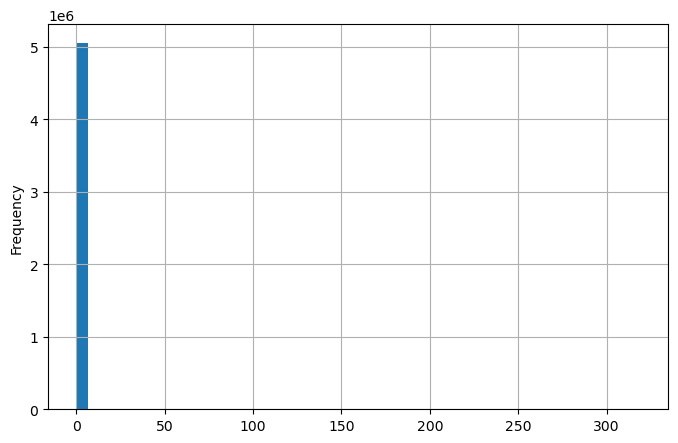

In [6]:
factor_final.stack().plot(kind='hist', bins=50, figsize=(8, 5)).grid()

# Define some calculation functions

In [7]:
####################################################
#                   DO NOT change                  #
####################################################
# N Groups & Calculate Perf & ICIR & visualization functions

def CumCal(s_: pd.Series, method='cumsum'):
    return s_.cumsum() if method == 'cumsum' else (1 + s_).cumprod() - 1

def bktest_buy_system(data_pack, _factor_final, _NUM: Union[tuple, int], freq: int,weighted_method):
    _factor_final = _factor_final.copy()
    _pos = data_pack['close'] * np.nan
    pos1 = _pos.copy().loc[_factor_final.index]
    pos2 = pos1.iloc[np.arange(0, len(pos1), freq), :]
    del pos1
    _factor_final = _factor_final.loc[pos2.index, :]
    if isinstance(_NUM, tuple):
        factor_final_rank = _factor_final.rank(axis=1, method='max', pct=True, ascending=False)
        factor_final_rank_num = (factor_final_rank > (NUM[0] / 100.0)) & (factor_final_rank <= (NUM[1] / 100.0))
    else:
        factor_final_rank = _factor_final.rank(axis=1, method='max', ascending=False)
        factor_final_rank_num = (factor_final_rank <= _NUM)
    factor_final_rank_num = factor_final_rank_num * 1
    _pos.loc[pos2.index] = factor_final_rank_num
    _pos = _pos.shift(1)
    _pos = _pos.ffill()

    file = (_factor_final if weighted_method == 'fw' or weighted_method == 'as_signal' else
            data_pack_all['total_mv'] if weighted_method == 'vw' else None)
    if file is not None:
        file.loc[list(set(file.index) - set(pos2.index))] = np.nan
        file = file.shift(1)
        file = file.fillna(method='ffill')
    else:
        pass
    _pos = (
        _pos.div(_pos.sum(axis=1), axis=0) if weighted_method == 'ew' else
        file[(_pos > 0.0)].div(file[(_pos > 0.0)].sum(axis=1), axis=0)
    )

    return _pos

def bktest_calculate_performance(data_pack, index_code, _IndexPri, ori_pos, TxFee, Freq) -> [pd.Series,pd.DataFrame]:
    ori_pos = ori_pos[data_pack['return'].columns]
    profitframe = ori_pos * np.nan
    commission = ori_pos * np.nan
    if Freq == 1:

        pre_post_pos = (ori_pos.shift(1) * (1 + data_pack['return'])) - ori_pos
        commission[pre_post_pos>0] = pre_post_pos * TxFee
        commission[pre_post_pos<=0] = 0.0
        profitframe[(ori_pos > 0.0)] = data_pack['return'] - commission
        profitframe.iloc[0,:] = profitframe.iloc[0,:] - 0.2 * TxFee
        stockprofit = (profitframe * ori_pos).sum(axis=1)
    else:
        group_tmp_ret = data_pack['return'].copy() + 1
        _date_index = pd.DatetimeIndex(
            group_tmp_ret.iloc[np.arange(0, group_tmp_ret.shape[0], Freq), :].index
        )
        group_tmp_ret = group_tmp_ret.assign(
            groups=pd.cut(group_tmp_ret.index, bins=_date_index, right=True)
        )
        data_pack['GroupCumRet'] = (
            group_tmp_ret
            .groupby('groups', as_index=False, group_keys=False)
            .apply(lambda df: df.drop('groups', axis=1).prod() - 1)
        )

        data_pack['GroupCumRet'].drop('groups', axis=1, inplace=True)
        data_pack['GroupCumRet'].index = _date_index.values[:-1]

        pos_like = ori_pos * np.nan
        GroupCumRet_lag1 = data_pack['GroupCumRet'].shift(1)
        pos_like.loc[GroupCumRet_lag1.index, :] = GroupCumRet_lag1.copy()

        pre_post_pos = (ori_pos * (pos_like.fillna(0) + 1)).shift(1) - ori_pos
        commission[pre_post_pos>0] = pre_post_pos * TxFee
        commission[pre_post_pos<=0] = 0.0
        profitframe[(ori_pos > 0.0)] = data_pack['return'] - commission + 1
        profitframe.iloc[0,:] = profitframe.iloc[0,:] - 0.2 * TxFee
        profitframe = profitframe.assign(
            groups=pd.cut(profitframe.index, bins=_date_index, right=True)
        )
        grouped_df = (ori_pos *
                      (profitframe
                       .groupby('groups', as_index=False, group_keys=False)
                       .apply(lambda df: df.drop('groups', axis=1).cumprod().shift(1).fillna(1))))
        profitframe.drop('groups', axis=1, inplace=True)
        profitframe = profitframe - 1
        grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)
        stockprofit = (grouped_df * profitframe).sum(axis=1)
        stockprofit = stockprofit.loc[:_date_index[-1], ]

    if index_code == 'all_A':
        all_ret = data_pack['return']
        all_ret.index = pd.to_datetime(all_ret.index)
        all_ret[all_ret > 20] = np.nan
        all_ret = all_ret[
            (all_ret.index >= stockprofit.index[0]) & (all_ret.index <= stockprofit.index[-1])]
        index_profit = all_ret.mean(axis=1)

    else:
        zz500 = _IndexPri[index_code]
        zz500.index = pd.to_datetime(zz500.index)
        zz500_ret = zz500.pct_change()
        zz500_ret = zz500_ret[
            (zz500_ret.index >= stockprofit.index[0]) & (zz500_ret.index <= stockprofit.index[-1])]
        index_profit = zz500_ret
    profit_df = pd.concat([stockprofit, index_profit], axis=1)
    profit_df.columns = ['strategy', index_code]
    profit_df.fillna(0)
    return profit_df

def bktest_details_of_performance(profit_sample, pos, TxFee, freq, cum_method, i):
    para_performance = [0.0] * 11
    if len(profit_sample) == 0:
        return pd.DataFrame(para_performance, columns=[i],
                            index=['AnnualRet', 'AnnualVol', 'SharpRatio', 'WinningRate',
                                   'MaxDrawDown', 'DrawDownStart', 'DrawDownEnd', 'MaxDrawDownDays',
                                   'TurnOverRate', 'TurnOverCost', 'freq'])
    para_performance[0] = round(AnnualProfit(profit_sample, opt=1, method=cum_method), 4)
    para_performance[1] = round(SD(profit_sample, opt=1), 4)
    para_performance[2] = round(
        Sharp(AnnualProfit(profit_sample, opt=1, method=cum_method), SD(profit_sample, opt=1)), 2)
    para_performance[3] = round(WinningRate(profit_sample, pos), 4)
    para_performance[4], para_performance[5], para_performance[6], para_performance[7] = MAX_Draw_down_period(
        profit_sample)
    para_performance[8] = round(TurnOverRate(pos), 4)
    para_performance[9] = round(TurnOverCost(para_performance[8], TxFee, 1), 2)
    para_performance[10] = freq
    para_performance = pd.DataFrame(para_performance, columns=[i],
                                    index=['AnnualRet', 'AnnualVol', 'SharpRatio', 'WinningRate',
                                           'MaxDrawDown', 'DrawDownStart', 'DrawDownEnd', 'MaxDrawDownDays',
                                           'TurnOverRate', 'TurnOverCost', 'freq'])
    return para_performance

def top_alpha_analyse(data_pack, _pos, _index_pri, _index_code, _TxFee, _freq, _CumMethod, perf_tile):
    _StrategyIndex_profit = (
        bktest_calculate_performance(
            data_pack, _index_code, _index_pri, _pos, _TxFee, _freq)
    )
    TopProfit = CumCal(StrategyIndex_profit['strategy'].dropna(), method=_CumMethod)
    TopAlpha = _StrategyIndex_profit['strategy'] - _StrategyIndex_profit[_index_code]
    TopAlpha = CumCal(TopAlpha.dropna(), method=_CumMethod)
    TopAlpha_performance = bktest_details_of_performance(
        TopAlpha, _pos, _TxFee, _freq, _CumMethod, perf_tile
    )
    return TopProfit, TopAlpha, TopAlpha_performance

def rolling_prod(a: pd.DataFrame, n=10):
    _rolling_df = a.cumprod().fillna(1)
    _rolling_df.iloc[n:, :] = (_rolling_df.iloc[n:, :].values / _rolling_df.iloc[:-n, :].values)
    _rolling_df.iloc[:n - 1, :] = np.nan
    return _rolling_df

def bktest_histogram_of_signal(_factor, title):
    data = np.reshape(np.array(_factor), (len(_factor.index) * len(_factor.columns)))
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=50)
    Title = title
    plt.title(Title)
    plt.grid(True)

def bktest_plot_para_performance(para_per, title):
    plt.figure(figsize=(8, 5))
    para_per.plot.bar()
    Title = title
    plt.title(Title)
    plt.grid(True)
    plt.show()

def bktest_plot_performance(profit, title):
    plt.figure(figsize=(8, 5))
    plt.plot(profit, 'r', label='')
    Title = title
    plt.title(Title)
    plt.grid(True)
    plt.show()

def bktest_plot_performance_by_groups(profit, title):
    plt.figure(figsize=(18, 9))
    for i in profit.columns:
        plt.plot(profit[i], label=i)
    Title = title
    plt.title(Title)
    # 设置图例样式
    plt.legend()#loc=2, fontsize=10)
    plt.grid(True)
    plt.show()

def bktest_plot_bar_IC_RankIC(para_per, title):
    para_per.plot(figsize=(8, 5), kind='bar')
    Title = title
    plt.title(Title)
    plt.grid(True)

def bktest_plot_ICIR(_df_cumIC, _df_cum_rankIC, title):
    _df_cumIC.plot(figsize=(8, 5), label='cumulative IC')
    _df_cum_rankIC.plot(label='cumulative rank IC', rot=20)
    plt.title(title)
    plt.grid()
    plt.legend()

In [8]:
####################################################
#                   DO NOT change                  #
####################################################
Profits_dict = defaultdict()
Profits_dict['group_stocks'] = dict()
for idx, NUM in enumerate(config_dict['num_tuple']):
    pos = bktest_buy_system(data_pack_all, factor_final, NUM, config_dict['freq'],
                            weighted_method=config_dict['weight_method'])

    StrategyIndex_profit = (
        bktest_calculate_performance(data_pack_all, config_dict['index_code'],
                                     IndexPri, pos, config_dict['TxFee'], config_dict['freq'])
    )
    Strategy_profit = CumCal(StrategyIndex_profit['strategy'].dropna(), method=config_dict['cumMethod'])
    profit_frame = pd.DataFrame(Strategy_profit)
    profit_frame.columns = [idx + 1]

    Index_profit = CumCal(StrategyIndex_profit[config_dict['index_code']].dropna(), method=config_dict['cumMethod'])
    index_frame = pd.DataFrame(Index_profit)
    index_frame.columns = [idx + 1]

    alpha = StrategyIndex_profit['strategy'] - StrategyIndex_profit[config_dict['index_code']]
    alpha_profit = CumCal(alpha.dropna(), method=config_dict['cumMethod'])
    alpha_frame = pd.DataFrame(alpha_profit)
    alpha_frame.columns = [idx + 1]
    alpha_performance = bktest_details_of_performance(
        alpha_profit, pos, config_dict['TxFee'], config_dict['freq'], config_dict['cumMethod'],idx + 1)

    if 'profit_frame' not in Profits_dict:
        Profits_dict['profit_frame'] = profit_frame
        Profits_dict['alpha_frame'] = alpha_frame
        Profits_dict['alpha_perf'] = alpha_performance
    else:
        tmp1 = Profits_dict['profit_frame'].copy()
        Profits_dict['profit_frame'] = pd.merge(tmp1, profit_frame, how='outer',
                                                left_index=True, right_index=True)
        tmp5 = Profits_dict['alpha_frame'].copy()
        Profits_dict['alpha_frame'] = pd.merge(tmp5, alpha_frame, how='outer',
                                               left_index=True, right_index=True)

        tmp6 = Profits_dict['alpha_perf'].copy()
        Profits_dict['alpha_perf'] = pd.merge(tmp6, alpha_performance, how='outer',
                                              left_index=True, right_index=True)

del tmp1, tmp5, tmp6
gc.collect()

0

In [9]:
Profits_dict['alpha_perf']

,1,2,3,4,5,6,7,8,9,10
AnnualRet,-0.2375,-0.0961,-0.0985,-0.0332,0.0485,0.078,0.0883,0.1015,0.1066,0.0939
AnnualVol,0.0685,0.0782,0.0747,0.0787,0.09,0.0953,0.0995,0.1061,0.1114,0.1098
SharpRatio,-3.47,-1.23,-1.32,-0.42,0.54,0.82,0.89,0.96,0.96,0.86
WinningRate,0.4877,0.5007,0.5007,0.4945,0.5048,0.4993,0.5069,0.5082,0.5034,0.5082
MaxDrawDown,-0.8029,-0.6143,-0.569,-0.4094,-0.2251,-0.1867,-0.2054,-0.1979,-0.1995,-0.1981
DrawDownStart,2017/01/05,2017/01/04,2017/01/04,2017/01/05,2020/09/09,2020/09/07,2020/09/09,2020/09/09,2020/09/09,2020/09/09
DrawDownEnd,2021/02/10,2021/02/10,2021/02/10,2021/02/10,2021/02/10,2021/02/10,2021/02/10,2021/02/10,2021/02/10,2021/02/10
MaxDrawDownDays,1497,1498,1498,1497,154,156,154,154,154,154
TurnOverRate,0.0576,0.0982,0.1231,0.1503,0.1681,0.1784,0.1805,0.1731,0.1503,0.0767
TurnOverCost,0.02,0.04,0.05,0.06,0.06,0.07,0.07,0.06,0.06,0.03


# Plot CumulativeReturn & Alpha of N-Groups

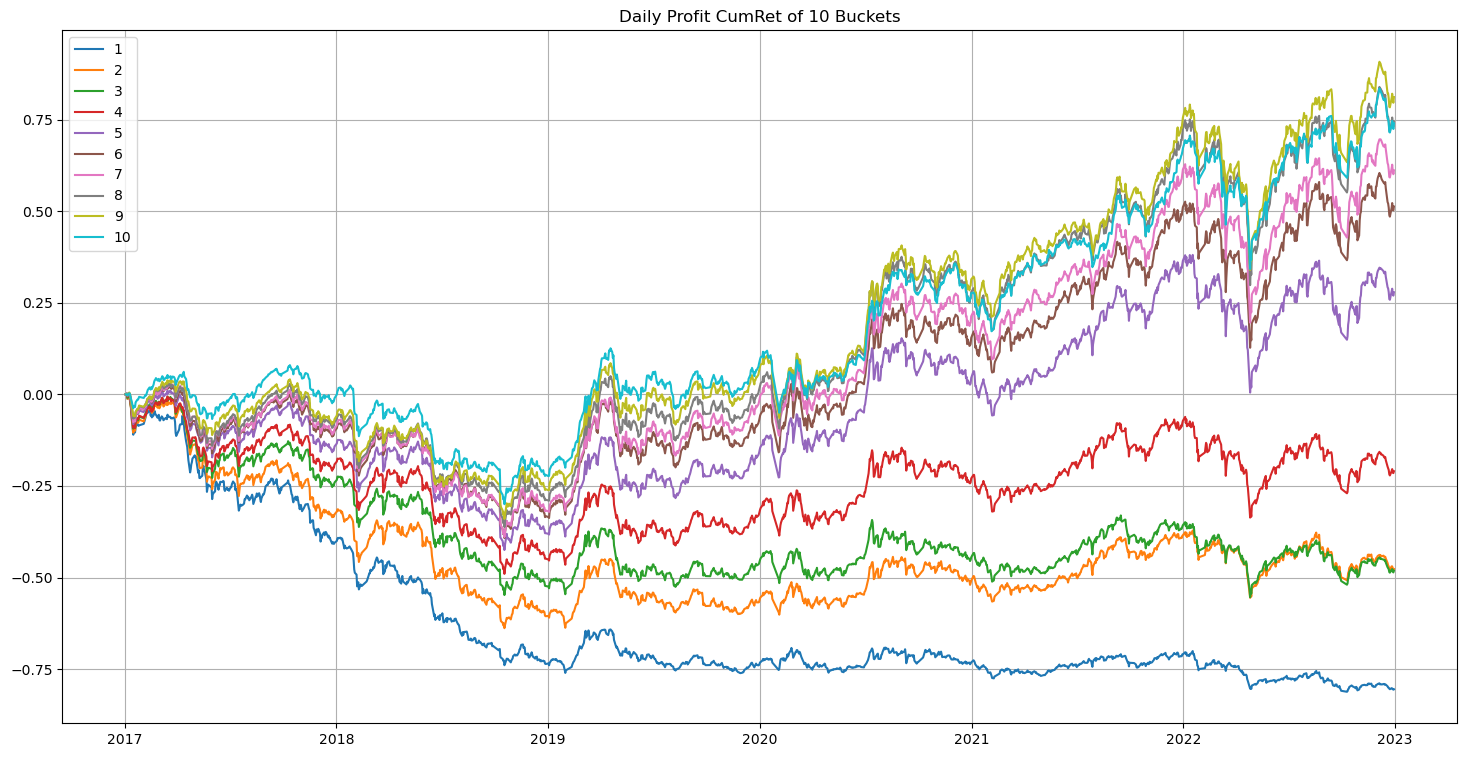

In [10]:
bktest_plot_performance_by_groups(
    Profits_dict['profit_frame'],title='Daily Profit CumRet of ' + str(config_dict['group_num']) + ' Buckets'
)

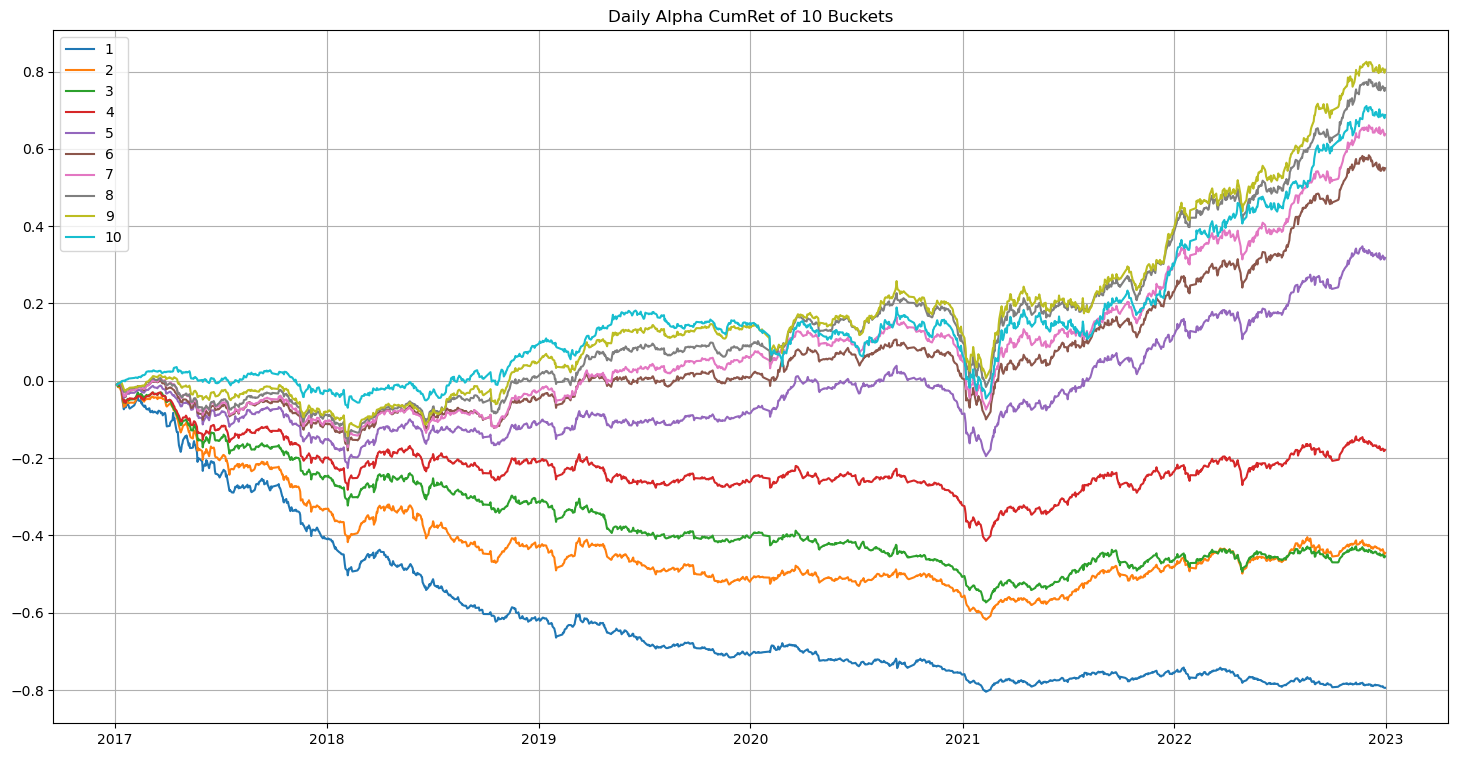

In [11]:
bktest_plot_performance_by_groups(
    Profits_dict['alpha_frame'],title='Daily Alpha CumRet of ' + str(config_dict['group_num']) + ' Buckets'
)

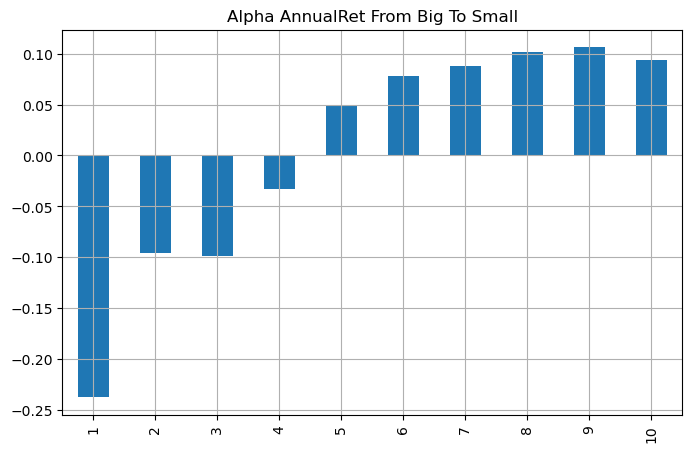

In [12]:
bktest_plot_para_performance(Profits_dict['alpha_perf'].T['AnnualRet'], 'Alpha AnnualRet From Big To Small')

# Long-Short Portfolio performance

In [13]:
# The TurnOverRate and TurnOverCost will always be 0 since they are not meaningful
# If you want to observe the TurnOverRate and TurnOverCost of each group, please refer to the detailed indicators of each group above
Profits_dict['long_short'] = (
    Profits_dict['profit_frame'].iloc[:, -1] -
    Profits_dict['profit_frame'].iloc[:, 0]
)
Profits_dict['LS_perf'] = bktest_details_of_performance(
    Profits_dict['long_short'], pd.DataFrame(index=Profits_dict['long_short'].index), 0.0, config_dict['freq'], config_dict['cumMethod'], 'long_short')  # 对冲的Tx_fee
Profits_dict['LS_perf']

,long_short
AnnualRet,0.1736
AnnualVol,0.1619
SharpRatio,1.07
WinningRate,0.523
MaxDrawDown,-0.1117
DrawDownStart,2022/01/12
DrawDownEnd,2022/04/26
MaxDrawDownDays,104
TurnOverRate,0.0
TurnOverCost,0.0


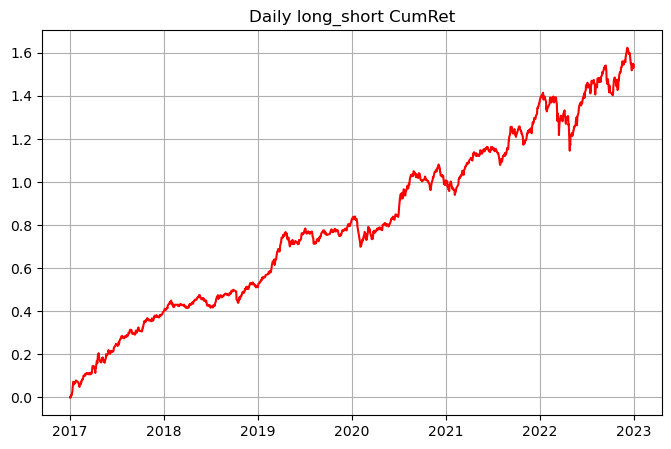

In [14]:
Profits_dict['long_short'].index = pd.to_datetime(Profits_dict['long_short'].index)
bktest_plot_performance(
    Profits_dict['long_short'],title='Daily long_short CumRet'
)

# bottom_num Portfolio performance
多头组(因子值最小的bottom_num只股票)表现

In [15]:
if isinstance(config_dict['bottom_num'], int):
    config_dict['bottom_num'] = [config_dict['bottom_num']]
else:
    pass

for Num in config_dict['bottom_num']:
    pos_Top = bktest_buy_system(
        data_pack_all, (- factor_final), Num, config_dict['freq'],config_dict['weight_method'])
    top_profit, top_alpha, top_perf = (
        top_alpha_analyse(data_pack_all, pos_Top, IndexPri, config_dict['index_code'],
                          config_dict['TxFee'], config_dict['freq'],config_dict['cumMethod'],f'Top={Num}'))
    top_profit = top_profit.to_frame(name=str(Num))
    top_alpha = top_alpha.to_frame(name=str(Num))
    if 'TopAlpha_BottomNum' in Profits_dict:
        tmp1 = Profits_dict['TopAlpha_BottomNum'].copy()
        Profits_dict['TopAlpha_BottomNum'] = pd.merge(tmp1, top_alpha, how='outer',
                                                   left_index=True, right_index=True)
        tmp2 = Profits_dict['TopPerf_BottomNum'].copy()
        Profits_dict['TopPerf_BottomNum'] = pd.concat([tmp2, top_perf],axis=1).reindex(tmp2.index)
    else:
        Profits_dict['TopAlpha_BottomNum'] = top_alpha
        Profits_dict['TopPerf_BottomNum'] = top_perf


In [16]:
Profits_dict['TopPerf_BottomNum']

,Top=400,Top=200
AnnualRet,0.0946,0.0705
AnnualVol,0.1095,0.1034
SharpRatio,0.86,0.68
WinningRate,0.5103,0.513
MaxDrawDown,-0.1972,-0.2274
DrawDownStart,2020/09/09,2019/06/06
DrawDownEnd,2021/02/10,2021/02/10
MaxDrawDownDays,154,615
TurnOverRate,0.0718,0.088
TurnOverCost,0.03,0.03


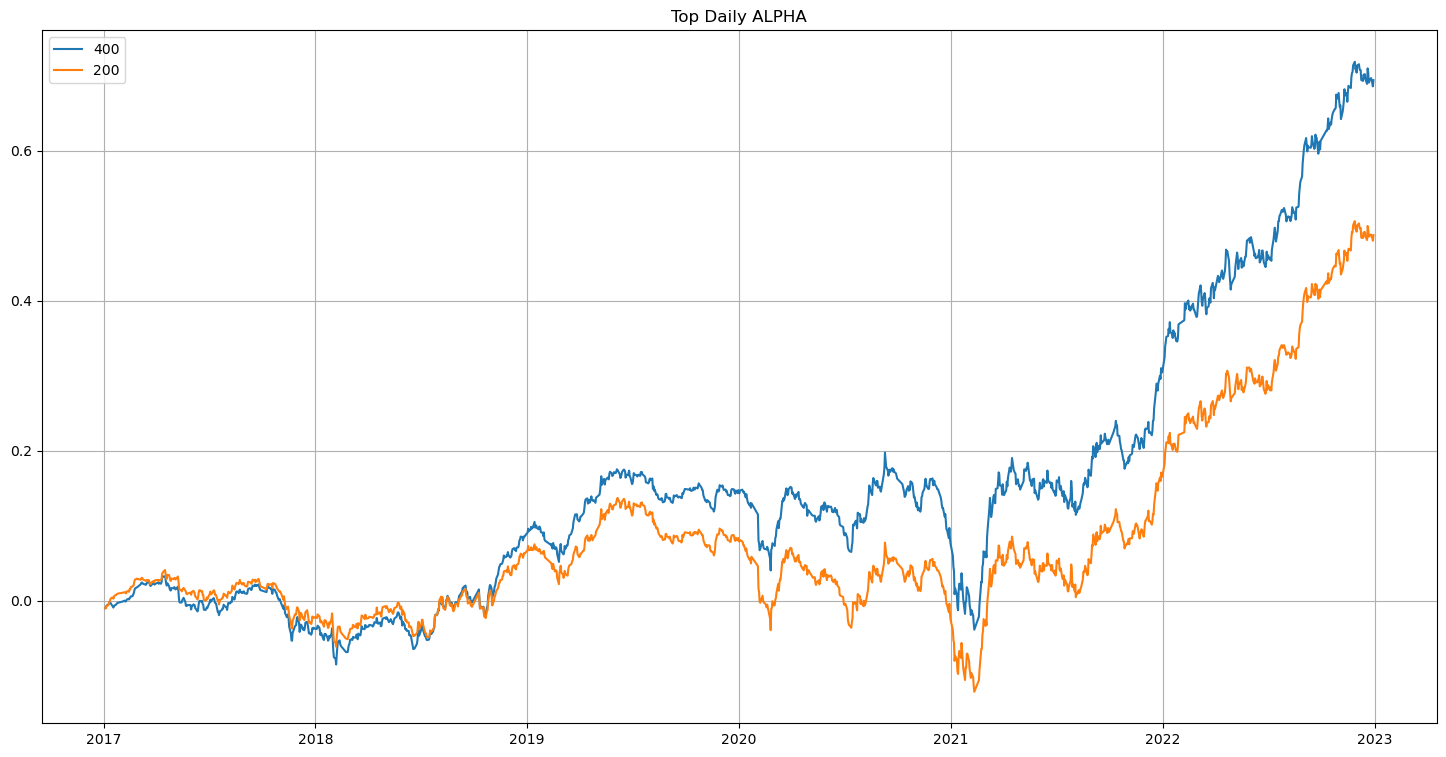

In [17]:
Profits_dict['TopAlpha_BottomNum'].index = pd.to_datetime(Profits_dict['TopAlpha_BottomNum'].index)
bktest_plot_performance_by_groups(Profits_dict['TopAlpha_BottomNum'], 'Top Daily ALPHA')

# IC-IR

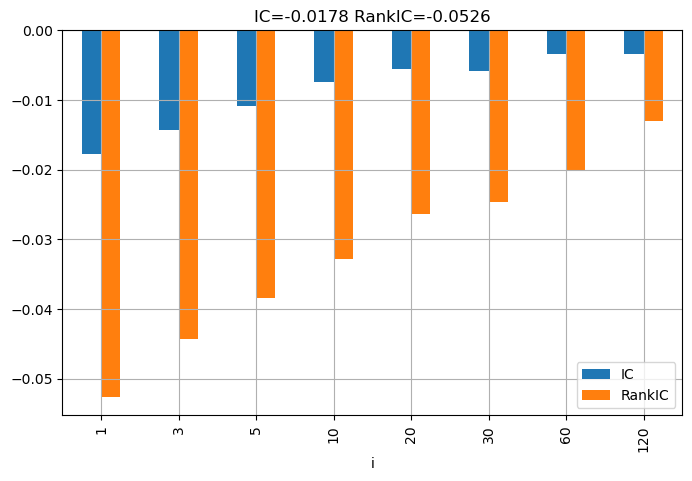

In [18]:
ret = data_pack_all['return'].copy()
rolling_step1_ret = rolling_prod(1 + ret, n=config_dict['freq']).shift(- config_dict['freq']) - 1
date_index = pd.DatetimeIndex(
    ret.iloc[np.arange(0, ret.shape[0], config_dict['freq']), :].index
)
df_Freq_factor = factor_final.loc[date_index, :]
cumICIR_dict = defaultdict(dict)
shift_range = [1, 3, 5, 10, 20, 30, 60, 120]

def loop_calc_icir_info(df_factor, df_ret, _cumICIR_dict):
    ic_list, icir_list, rankIC_list, rankICIR_list = [], [], [], []
    df_factor_T = df_factor.T
    for i in shift_range:
        df_FreqRet = df_ret.iloc[np.arange(i, factor_final.shape[0], config_dict['freq']), :].copy()
        df_FreqRet.index = df_factor.iloc[:df_FreqRet.shape[0], :].index
        shiftRet_T = df_FreqRet.T

        df_ic = df_factor_T.corrwith(shiftRet_T)
        df_rank_ic = df_factor_T.corrwith(shiftRet_T, method='spearman')
        ic_list.append(round(df_ic.mean(), 4))
        icir_list.append(round(df_ic.mean() / df_ic.std(), 4))
        rankIC_list.append(round(df_rank_ic.mean(), 4))
        rankICIR_list.append(round(df_rank_ic.mean() / df_rank_ic.std(), 4))
        _cumICIR_dict[str(i)] = {'df_cumIC': df_ic.cumsum(), 'df_cum_rankIC': df_rank_ic.cumsum()}

    df1 = pd.DataFrame(
        {'i': shift_range, 'IC': ic_list, 'ICIR': icir_list, 'RankIC': rankIC_list,
         'rankICIR': rankICIR_list})
    df1 = df1.sort_values(by='i').set_index('i', drop=True)
    return df1.copy(),_cumICIR_dict

df_StepFreq,cumICIR_dict = loop_calc_icir_info(df_Freq_factor, rolling_step1_ret, cumICIR_dict)
bktest_plot_bar_IC_RankIC(
            df_StepFreq.loc[[1, 3, 5, 10, 20, 30, 60, 120], ['IC', 'RankIC']],
            title=f"IC={df_StepFreq.loc[1, 'IC']} "
                  f"RankIC={df_StepFreq.loc[1, 'RankIC']}"
        )

In [19]:
df_StepFreq

,IC,ICIR,RankIC,rankICIR
i,,,,
1,-0.0178,-0.1931,-0.0526,-0.3674
3,-0.0143,-0.1627,-0.0443,-0.3072
5,-0.0109,-0.1283,-0.0385,-0.2674
10,-0.0074,-0.0946,-0.0329,-0.2323
20,-0.0056,-0.0790,-0.0264,-0.1938
30,-0.0058,-0.0897,-0.0247,-0.1898
60,-0.0035,-0.0644,-0.0200,-0.1693
120,-0.0034,-0.0778,-0.0130,-0.1261


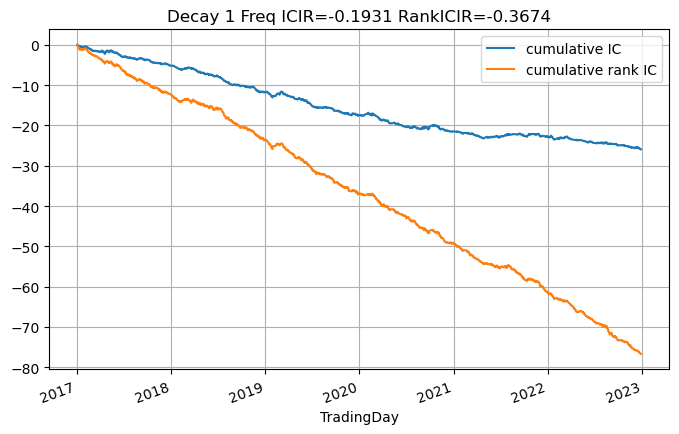

In [20]:
df_cumIC = cumICIR_dict['1']['df_cumIC']
df_cum_rankIC = cumICIR_dict['1']['df_cum_rankIC']
bktest_plot_ICIR(
            df_cumIC, df_cum_rankIC,
            title=f"Decay 1 Freq ICIR={df_StepFreq.loc[1, 'ICIR']} "
                  f"RankICIR={df_StepFreq.loc[1, 'rankICIR']}"
        )